# Analysis of the autism data


The objective of this notebook is to identify the CVA variable whom the missignness may be associated with the diagnosis. 
The hypothesis underlying the treatment of missing variables among the predictors is important as it can biased the estimated models and their prediction. 
One want to know whether the CVA variables should rather be hypothesized as Missing Completely at Random (MNAR; in which case it is not necessary to model their missignness as it could add noise to the model, we might event prevent the model to use such missingness as predictors (for post-hoc model interpretability analysis, we must control that the significant predictors of the diagnosis are not the missingness of MCAR variable), Missing at Random (MAR; in which case we also do not want to add the information thta it is missing explicitely, but rather model it implicitely by design of the algorithm (if one feature is missing, it might not directly  associated with the final diagnosis, but could condition the way other prdictors are handled by the model). Finally, the Missing Not at Random hypothesis (MNAR; one may want to explicitely model such missingness to add to the set of predictors).

Method.

1) We go over each of the missing block variables (features always missing together e.g. the touch features). 
2) We run a statstical test to control whether the diagnosis is a statistically significant contributor of having a feature missing. This could be done using an ANOVA. 
3) The features for who the diagnosis is a significant predictor will be accounted for in the model, either adding an indicator variable, or by modeling the missignness in the feature space. 

EDIT: This notebook is kept within the code package (1) for reviewers of the manuscript submitted to Nature Medicine in April 2023.
(1) It is mostly out of completeness that this notebook is included, but is mostly exploratory and did not lead to any precise results and/or numbers presented in the paper. In other words, the founding of this notebook has to be taken with a inch of salt. :-)


In [5]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [6]:
df = pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=False,
                use_missing_indicator_variables=False, #use_missing_indicator_variables,#grouped_missing_features,
               verbosity=0,
               scenario='multimodal_2023',#'papers',
               proportion_train=1)

467 administrations left.


,id
diagnosis,
0.0,417
1.0,50


In [7]:
variables_of_interest = DEFAULT_PREDICTORS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)


In [8]:
grouped_missing_features = {'Floating Bubbles': ['FB_postural_sway', 'FB_postural_sway_derivative'],
                             'DogInGrassC': ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
                             'DogInGrassRRL': ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
                             'SpinningTop': ['ST_postural_sway', 'ST_postural_sway_derivative'],
                            
                             'PlayingWithBlocks': ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
                             'FunAtThePark PS': ['FP_postural_sway', 'FP_postural_sway_derivative'], 
                             'FunAtThePark Gaze': ['FP_gaze_speech_correlation', 'FP_gaze_silhouette_score'],

                             'MechanicalPuppy': ['MP_postural_sway', 'MP_postural_sway_derivative'],
                             'BlowingBubbles PS': ['BB_postural_sway', 'BB_postural_sway_derivative'],
                             'BlowingBubbles Gaze': ['BB_gaze_percent_right', 'BB_gaze_percent_right'],
                            
                             'Social gaze': ['S_gaze_percent_right', 'S_gaze_silhouette_score'],
                             'Silhouette Score': ['gaze_silhouette_score'],    
                             'Gaze percent Right': ['mean_gaze_percent_right'], 
                            
                            'S PosturalSway':['S_postural_sway'], 
                            'NS PosturalSway':['NS_postural_sway'], 
                            
                            'S PosturalSwayDerivative':['S_postural_sway_derivative'], 
                            'NS PosturalSwayDerivative':['NS_postural_sway_derivative'],                             
                            
                             'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative'],
                             'MakeMeLaugh': ['MML_postural_sway', 'MML_postural_sway_derivative'],
                            
                             'RTN': ['proportion_of_name_call_responses'],
                             'RTNB': ['name_call_response_binary'],
                             'RTNDelay': ['average_response_to_name_delay'],
                            
                             'Game administration': ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
                             'NoTouches': ['average_length',
                                                  'std_length',
                                                  'pop_rate',
                                                  'average_touch_duration',
                                                  'std_touch_duration',
                                                  'average_accuracy_variation',
                                                  'accuracy_consistency'],
                             'TimeSpent': ['average_time_spent', 'std_time_spent']}


def having_missing(df, features, contrary=True):
    if not contrary:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
def select(df, feat, value):
    return df[df[feat]==value]

In [9]:
for name_missing, feature_missing  in grouped_missing_features.items():
    
    print("{} {}% with {:.2f} NT and {:.2f} autistic".format(name_missing, 100*len(having_missing(data.df, feature_missing, contrary=False))/len(data.df), 
                                                                 100*round(len(having_missing(select(data.df, 'diagnosis', 0), feature_missing, contrary=False))/len(select(data.df, 'diagnosis', 0)), 2), 
                                                                 100*round(len(having_missing(select(data.df, 'diagnosis', 1), feature_missing, contrary=False))/len(select(data.df, 'diagnosis', 1)), 2)))

Floating Bubbles 0.6423982869379015% with 0.00 NT and 2.00 autistic
DogInGrassC 1.9271948608137044% with 2.00 NT and 2.00 autistic
DogInGrassRRL 2.355460385438972% with 2.00 NT and 6.00 autistic
SpinningTop 5.139186295503212% with 5.00 NT and 8.00 autistic
PlayingWithBlocks 5.995717344753747% with 5.00 NT and 14.00 autistic
FunAtThePark PS 6.638115631691649% with 6.00 NT and 16.00 autistic
FunAtThePark Gaze 6.209850107066381% with 5.00 NT and 14.00 autistic
MechanicalPuppy 5.353319057815845% with 5.00 NT and 10.00 autistic
BlowingBubbles PS 5.995717344753747% with 5.00 NT and 14.00 autistic
BlowingBubbles Gaze 6.209850107066381% with 5.00 NT and 16.00 autistic
Social gaze 5.353319057815845% with 5.00 NT and 8.00 autistic
Silhouette Score 4.925053533190578% with 5.00 NT and 6.00 autistic
Gaze percent Right 5.139186295503212% with 5.00 NT and 8.00 autistic
S PosturalSway 4.710920770877944% with 5.00 NT and 6.00 autistic
NS PosturalSway 0.0% with 0.00 NT and 0.00 autistic
S PosturalSwayDe

In [10]:
select(data.df, 'diagnosis', 1)['name_call_response_binary'].isna().mean()

0.06

In [11]:
select(data.df, 'diagnosis', 1)['proportion_of_name_call_responses'].isna().mean()

0.02

# Analysis of Missing data patterns in the sample

Predicting diagnosis based on 58 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 56 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.


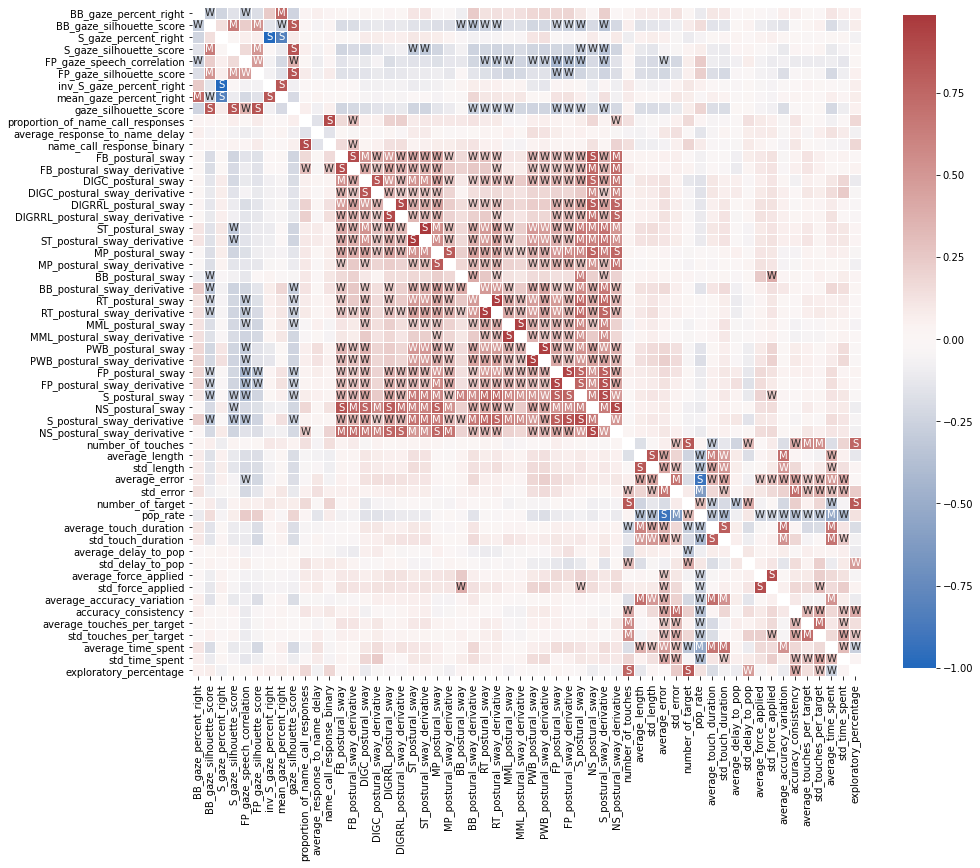

In [23]:
import missingno as msno
data.features_name = CVA_COLUMNS 

data.features_name = [f for f in data.features_name if f not in ['PB_postural_sway', 'PB_postural_sway_derivative', 'diagnosis']]

df_X = data.df[data.features_name]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

#plt.figure(figsize=(15, 15))
#df.isna().mean().sort_values().plot(kind="bar", figsize=(15, 4),
#                                    title="Percentage of missing values per feature")

Text(0, 0.5, 'Number of administration with this pattern missing.')

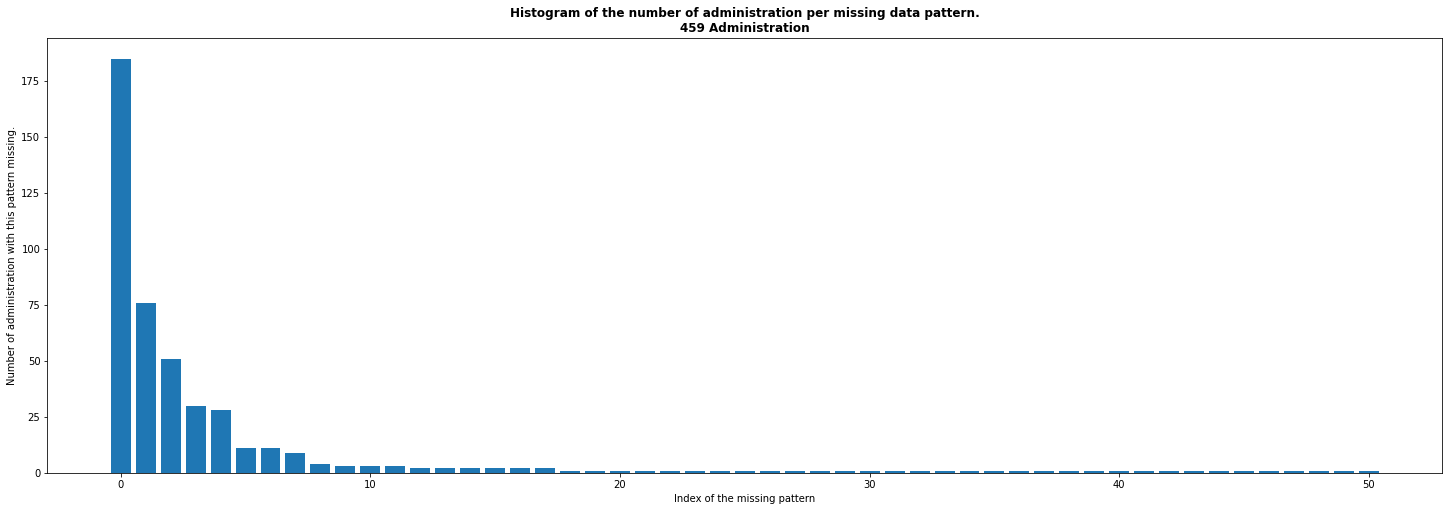

In [24]:
variables_of_interest = data.features_name


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(data.df["mdp"].value_counts().index))), height=data.df["mdp"].value_counts().to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(data.df)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")

Text(0, 0.5, 'Number of administration with this pattern missing.')

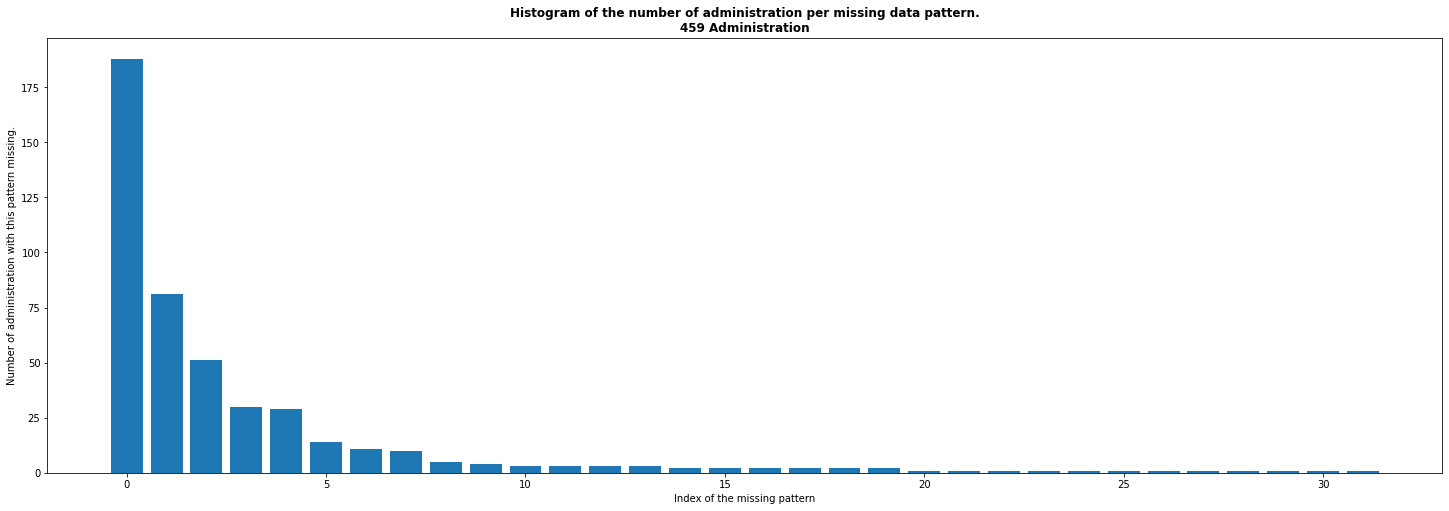

In [ ]:
variables_of_interest = data.features_name


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(data.df["mdp"].value_counts().index))), height=data.df["mdp"].value_counts().to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(data.df)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")

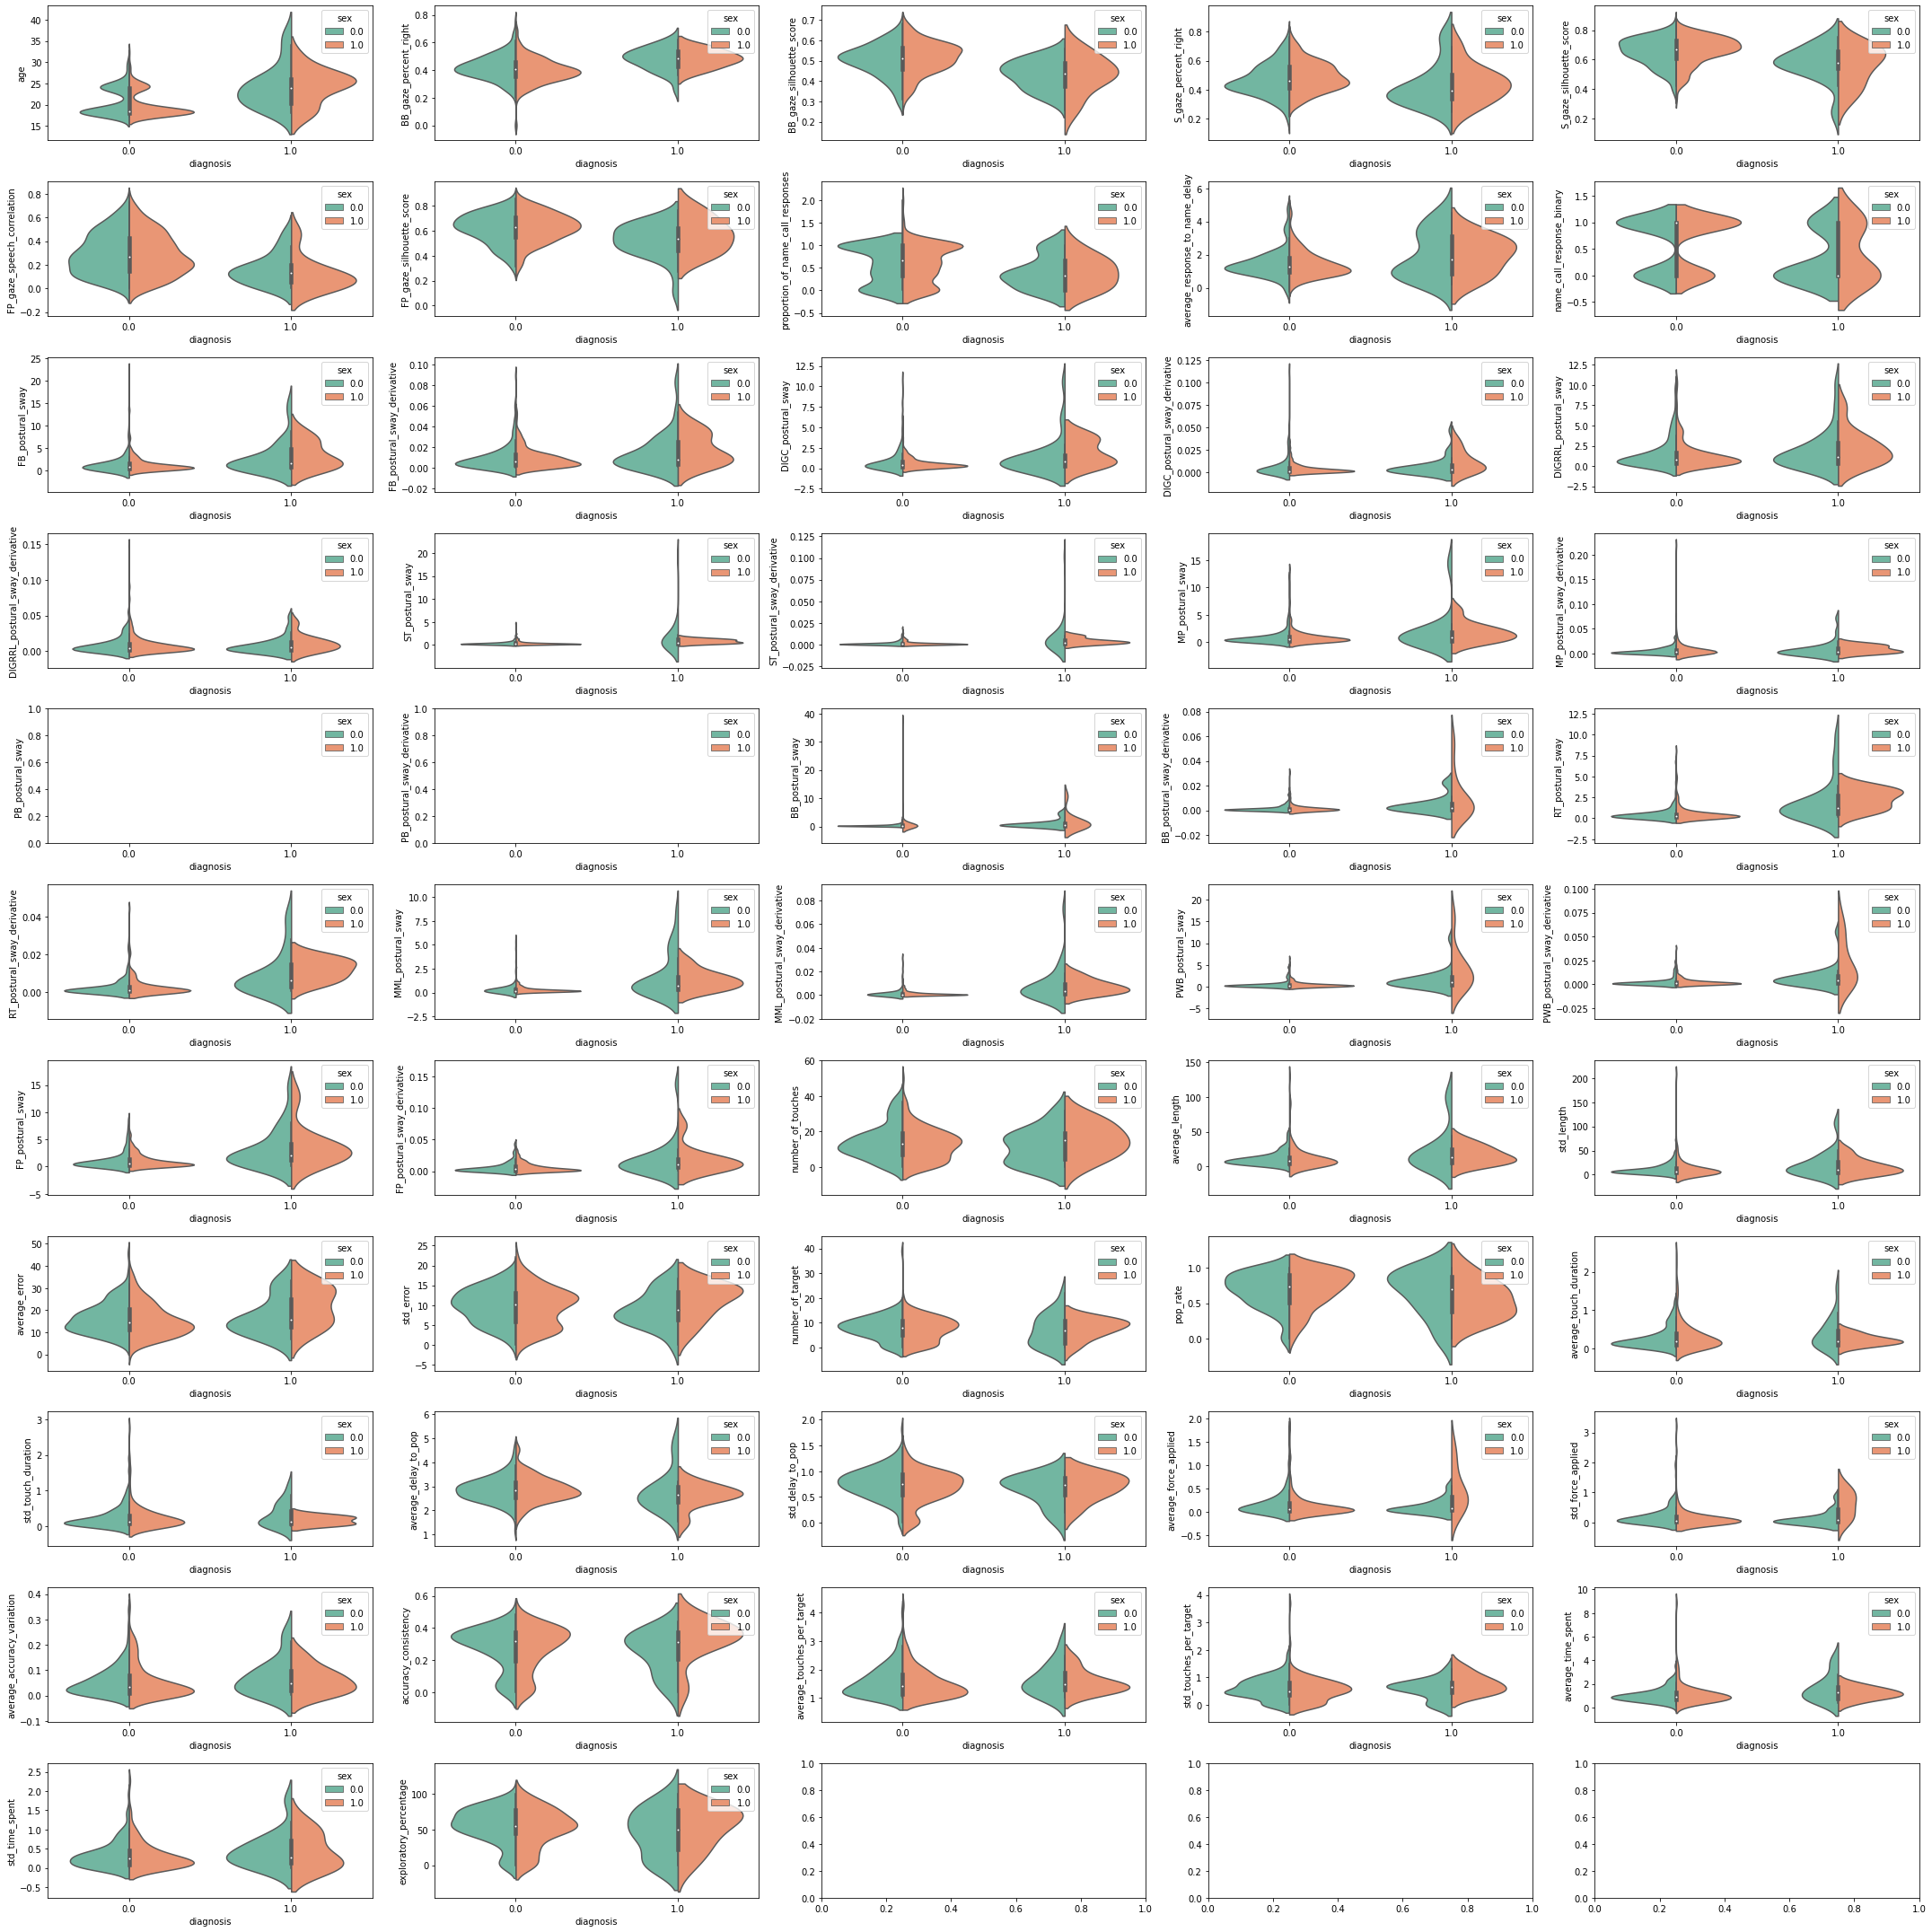

In [ ]:
selected_features = ['age'] + CVA_COLUMNS

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(30, 30))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=data.df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()

In [ ]:
variables_of_interest = CVA_COLUMNS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

In [8]:
print("Number of missing patterns: {} (over {} theoretically possible; 2^K)".format(n_pat, 2**len(variables_of_interest)))

Number of missing patterns: 51 (over 2251799813685248 theoretically possible; 2^K)


Text(0.5, 1.0, 'Features missing for the most frequent patterns. 459 adm (416 NT, 43 ASD)')

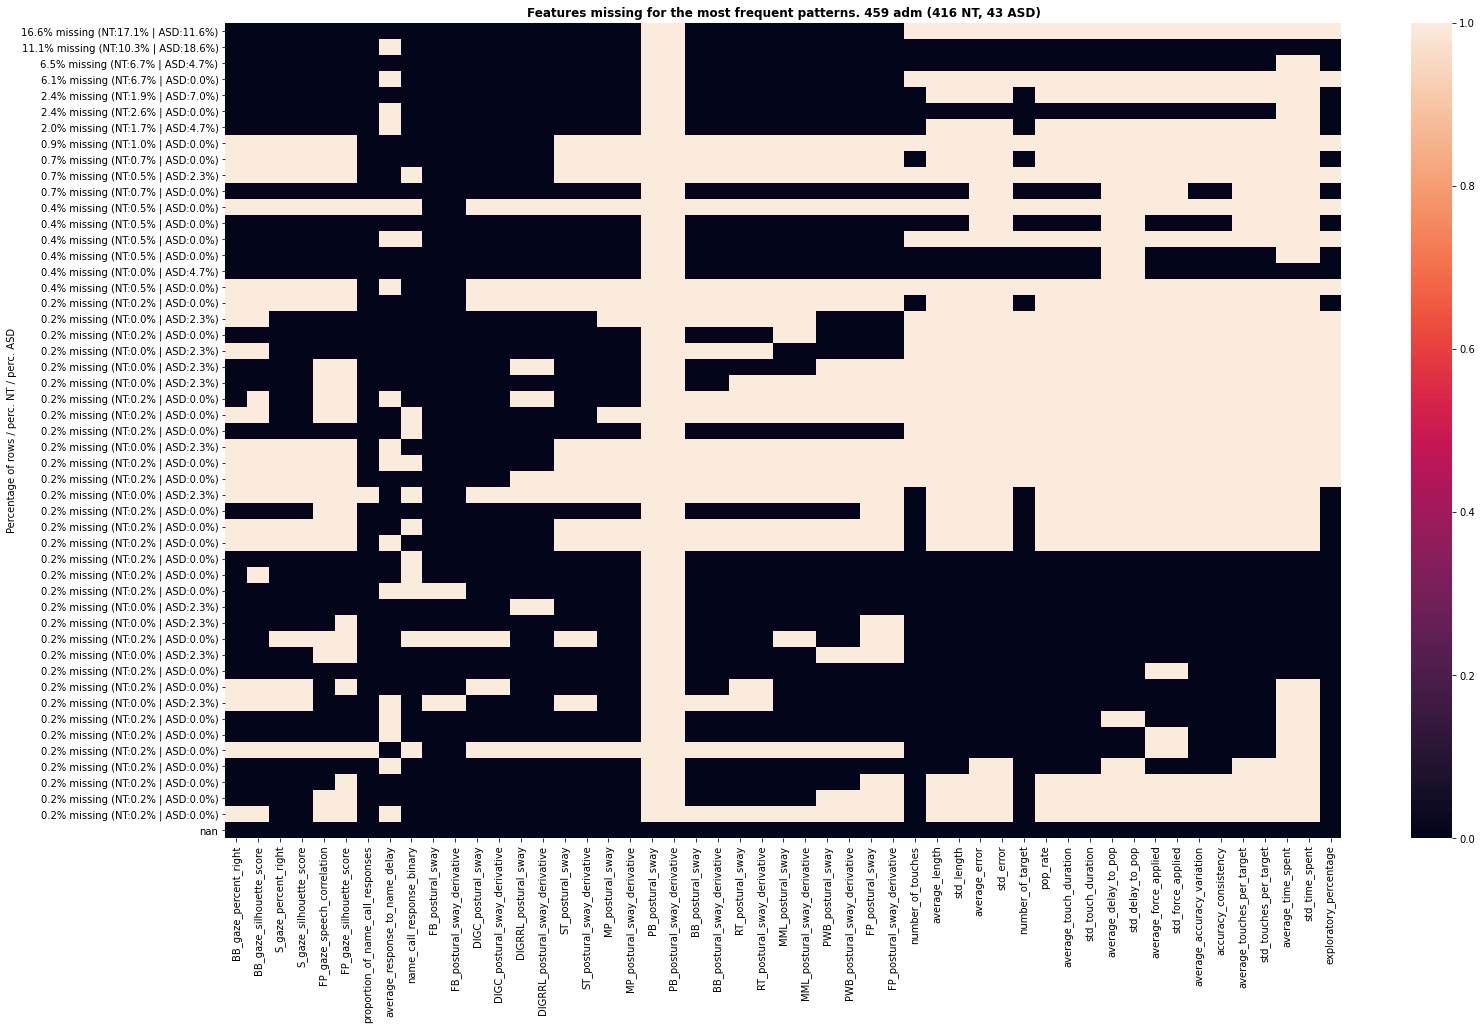

In [ ]:

matrix = pd.DataFrame(
            data=np.zeros(shape=(len(data.df["mdp"].value_counts().index), len(variables_of_interest)+1)),
            columns=variables_of_interest+['Percentage of rows'],
            index=data.df["mdp"].unique(),
        ).sort_index()



for pattern in sorted(data.df["mdp"].unique())[1:]:
    d = data.df.loc[data.df['mdp']==pattern, ['diagnosis'] + variables_of_interest]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(data.df)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}% missing (NT:{}% | ASD:{}%)".format(np.round(len(d)/len(data.df)*100,1), np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,1), np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,1))
matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, variables_of_interest].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(data.df), len(data.df[data.df['diagnosis']==0]), len(data.df[data.df['diagnosis']==1])), weight='bold')

In [87]:
grouped_features_label = {0:'Floating Bubbles',
                         1: 'DIGC',
                         2: 'DIGRRL',
                         3: 'ST',
                         4: 'Social PS',
                         5: 'PlayingWithBlocks',
                         6: 'FP',
                         7: 'MP',
                         8: 'BB',
                         9: 'RT',
                         10: 'MML',
                        11: 'Game', 
                        12: 'Game no touches', 
                        13: 'Game no force',
                        14: 'No touches per target',
                        15: 'delay to pop',
                        16: 'Game no grouped touches',
                        17: 'Peakaboo'}

dict_check_1_0 = {12:[11],
                 13:[11, 12],
                 13:[11, 12],
                 14:[11, 12],
                 15:[11, 12],
                 16:[11, 12],
                 }

grouped_features = {'Floating Bubbles': ['FB_postural_sway', 'FB_postural_sway_derivative'],
                             'DogInGrassC': ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
                             'DogInGrassRRL': ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
                             'SpinningTop': ['ST_postural_sway', 'ST_postural_sway_derivative'],
                            
                             'PlayingWithBlocks': ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
                             'FunAtThePark PS': ['FP_postural_sway', 'FP_postural_sway_derivative'], 
                             'FunAtThePark Gaze': ['FP_gaze_speech_correlation', 'FP_gaze_silhouette_score'],

                             'MechanicalPuppy': ['MP_postural_sway', 'MP_postural_sway_derivative'],
                             'BlowingBubbles PS': ['BB_postural_sway', 'BB_postural_sway_derivative'],
                             'BlowingBubbles Gaze': ['BB_gaze_percent_right', 'BB_gaze_percent_right'],
                            
                             'Social gaze': ['S_gaze_percent_right', 'S_gaze_silhouette_score'],
                             'Silhouette Score': ['gaze_silhouette_score'],    
                             'Gaze percent Right': ['mean_gaze_percent_right'], 
                            
                            'S PosturalSway':['S_postural_sway'], 
                            'NS PosturalSway':['NS_postural_sway'], 
                            
                            'S PosturalSwayDerivative':['S_postural_sway_derivative'], 
                            'NS PosturalSwayDerivative':['NS_postural_sway_derivative'],                             
                            
                             'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative'],
                             'MakeMeLaugh': ['MML_postural_sway', 'MML_postural_sway_derivative'],
                            
                             'RTN': ['proportion_of_name_call_responses'],
                             'RTNB': ['name_call_response_binary'],
                             'RTNDelay': ['average_response_to_name_delay'],
                            
                             'Game administration': ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
                             'NoTouches': ['average_length',
                                                  'std_length',
                                                  'pop_rate',
                                                  'average_touch_duration',
                                                  'std_touch_duration',
                                                  'average_accuracy_variation',
                                                  'accuracy_consistency'],
                             'TimeSpent': ['average_time_spent', 'std_time_spent']}
dict_check_1_0 = {'NoTouches':['Game administration'],
                 'TimeSpent':['NoTouches', 'Game administration'],
                 }

def df_missing_features(df, features, having_features_missing=True):
    if having_features_missing:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    

<AxesSubplot:ylabel='Percentage of rows / perc. NT / perc. ASD'>

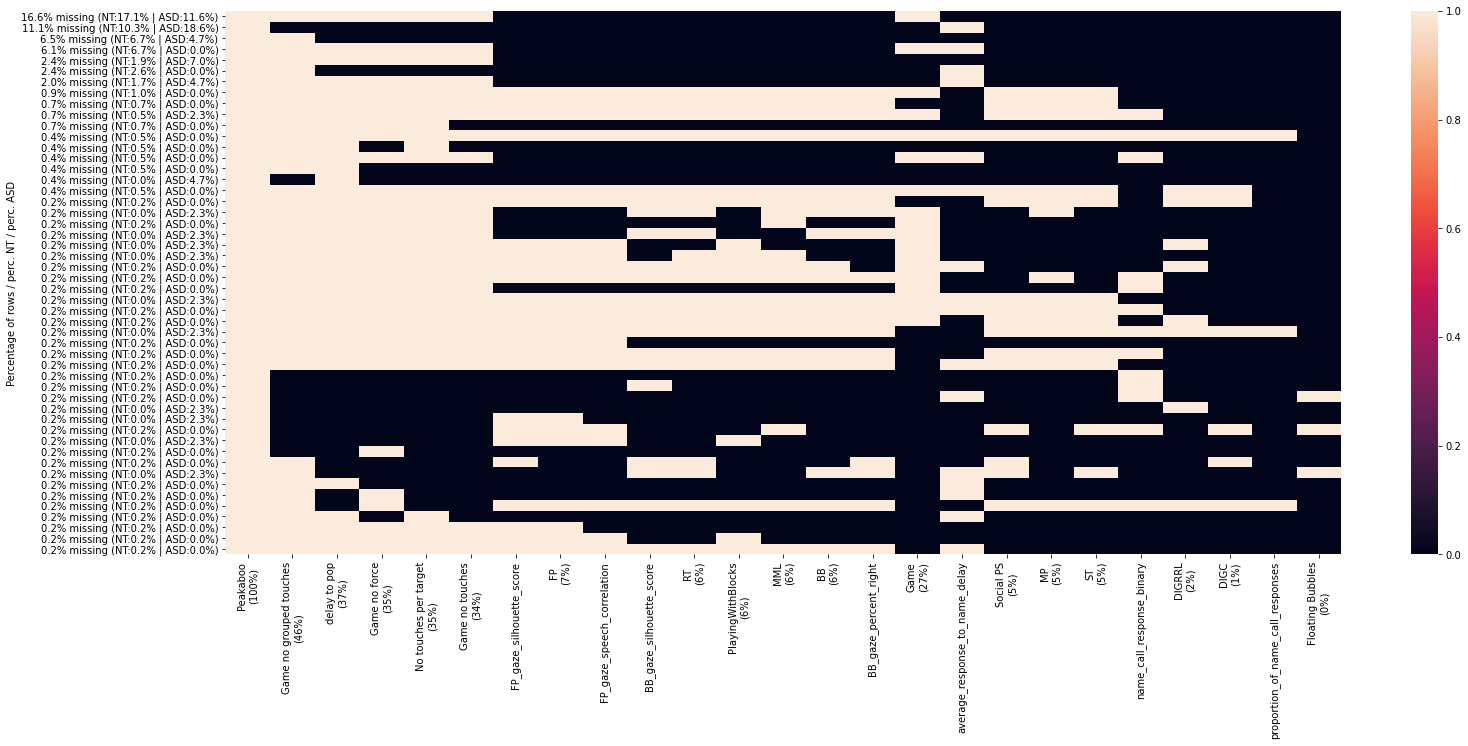

In [ ]:
matrix = matrix.loc[matrix['Percentage of rows'] >.1, :].transpose()

new_df = matrix.loc[['Percentage of rows / perc. NT / perc. ASD'], :].copy()
duplicated_rows = matrix[matrix.duplicated(keep=False)]

def df_missing_features(df, features, having_features_missing=True):
    if having_features_missing:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
grouped_features = {}
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    grouped_features[idx]=[]
    for col in f.index:
        grouped_features[idx].append(col)    
    
for i, feats in grouped_features.items():
    grouped_features_label[i] += "\n({}%)".format(int(len(df_missing_features(data.df, features=feats, having_features_missing=True))/len(data.df)*100))
    
    
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    index = ""
    for col in f.index:
        index+=col+"\n"
    index = index[:-1]
    new_df = new_df.append(pd.DataFrame(data=f.iloc[:1].to_numpy().astype(int), index=[grouped_features_label[idx]], columns=f.columns))
    

    
    
new_df = new_df.append(matrix[~matrix.duplicated(keep=False)].drop(index=['Percentage of rows','Percentage of rows / perc. NT / perc. ASD'])).transpose()
new_df.set_index('Percentage of rows / perc. NT / perc. ASD', inplace=True)
new_df = new_df.loc[:,list(new_df.sum(axis=0).sort_values(ascending=False).index)]

plt.figure(figsize=(25, 10))
sns.heatmap(new_df.astype(int))

## Adding the indicator variables to the dataframe

In [81]:

for i, feats in grouped_features.items():
    data.df['Z_grouped_{}'.format(i)] = 0
    data.df.loc[data.df.drop(index=data.df.dropna(subset=feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1


# Statistical tests on the missing data


In [82]:
from scipy.stats import chi2, ttest_ind

In [83]:
data.df['stimuli_version'] = data.df['path'].apply(lambda path: path.split('/')[-2])
data.df.loc[~data.df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'
data.df['stimuli_version'].value_counts()

Older_Than_18    459
Name: stimuli_version, dtype: int64

In [16]:
grouped_features = {0: ['FB_postural_sway', 'FB_postural_sway_derivative'],
 1: ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
 2: ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
 3: ['ST_postural_sway', 'ST_postural_sway_derivative'],
 4: ['S_gaze_percent_right', 'S_gaze_silhouette_score'],
 5: ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
 6: ['FP_postural_sway', 'FP_postural_sway_derivative'],
 7: ['MP_postural_sway', 'MP_postural_sway_derivative'],
 8: ['BB_postural_sway', 'BB_postural_sway_derivative'],
 9: ['RT_postural_sway', 'RT_postural_sway_derivative'],
 10: ['MML_postural_sway', 'MML_postural_sway_derivative'],
 11: ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
 12: ['average_length',
  'std_length',
  'pop_rate',
  'average_touch_duration',
  'std_touch_duration',
  'average_accuracy_variation',
  'accuracy_consistency'],
 13: ['average_force_applied', 'std_force_applied'],
 14: ['average_error',
  'std_error',
  'average_touches_per_target',
  'std_touches_per_target'],
 15: ['average_delay_to_pop', 'std_delay_to_pop'],
 16: ['average_time_spent', 'std_time_spent'],
 17: ['PB_postural_sway', 'PB_postural_sway_derivative']}

{0: ['FB_postural_sway', 'FB_postural_sway_derivative'],
 1: ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
 2: ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
 3: ['ST_postural_sway', 'ST_postural_sway_derivative'],
 4: ['S_gaze_percent_right', 'S_gaze_silhouette_score'],
 5: ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
 6: ['FP_postural_sway', 'FP_postural_sway_derivative'],
 7: ['MP_postural_sway', 'MP_postural_sway_derivative'],
 8: ['BB_postural_sway', 'BB_postural_sway_derivative'],
 9: ['RT_postural_sway', 'RT_postural_sway_derivative'],
 10: ['MML_postural_sway', 'MML_postural_sway_derivative'],
 11: ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
 12: ['average_length',
  'std_length',
  'pop_rate',
  'average_touch_duration',
  'std_touch_duration',
  'average_accuracy_variation',
  'accuracy_consistency'],
 13: ['average_force_applied', 'std_force_applied'],
 14: ['average_error',
  'std_error',
  'average_touches_per_tar

## Continuous Variables

In [104]:
variables_of_interest = list(grouped_features.values())
#data.filter(administration={'complete':True, 'order': 'first'})
from scipy.stats import mannwhitneyu

vars = ['age', 'mullen_el',  'mullen_fm','mullen_rl','mullen_vr','mullen_elc_std','ados_total',  'ados_rrb',
         'ados_sa','srs_total_tscore', 'srs_social_awareness_tscore',
         'srs_social_motivation_tscore',
         'cbcl_scaleIV_score',
         'cbcl_asd_score',
         'mchat_total']


mcar_matrix = pd.DataFrame(
    data=np.zeros(shape=(len(vars), len(variables_of_interest))),
    columns=list(grouped_features.keys()),
    index=vars,
)


In [105]:
for i, feats in grouped_missing_features.items():
    for j, var in enumerate(vars):
        
        d = data.df.copy()

        
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
        missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
        
        if len(having) < 20 or len(missing) < 20:
            mcar_matrix.loc[var, i] = np.nan
            continue
            
        mcar_matrix.loc[var, i] = mannwhitneyu(having, missing).pvalue #ttest_ind(having, missing, equal_var=False).pvalue


In [89]:
mcar_matrix

,Floating Bubbles,DogInGrassC,DogInGrassRRL,SpinningTop,PlayingWithBlocks,FunAtThePark PS,FunAtThePark Gaze,MechanicalPuppy,BlowingBubbles PS,BlowingBubbles Gaze,Social gaze,Silhouette Score,Gaze percent Right,S PosturalSway,NS PosturalSway,S PosturalSwayDerivative,NS PosturalSwayDerivative,RhymesAndToys,MakeMeLaugh,RTN,RTNB,RTNDelay,Game administration,NoTouches,TimeSpent
age,NaN,NaN,NaN,0.830888,0.674402,0.820726,0.701664,0.492727,0.391483,0.611649,0.989986,0.748877,0.859920,0.595056,NaN,0.595056,NaN,0.755542,0.602791,NaN,NaN,0.005587,0.004926,0.130570,0.392250
mullen_el,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mullen_fm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mullen_rl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mullen_vr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mullen_elc_std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ados_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ados_rrb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ados_sa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
srs_total_tscore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.637412,0.221289,NaN,0.516443


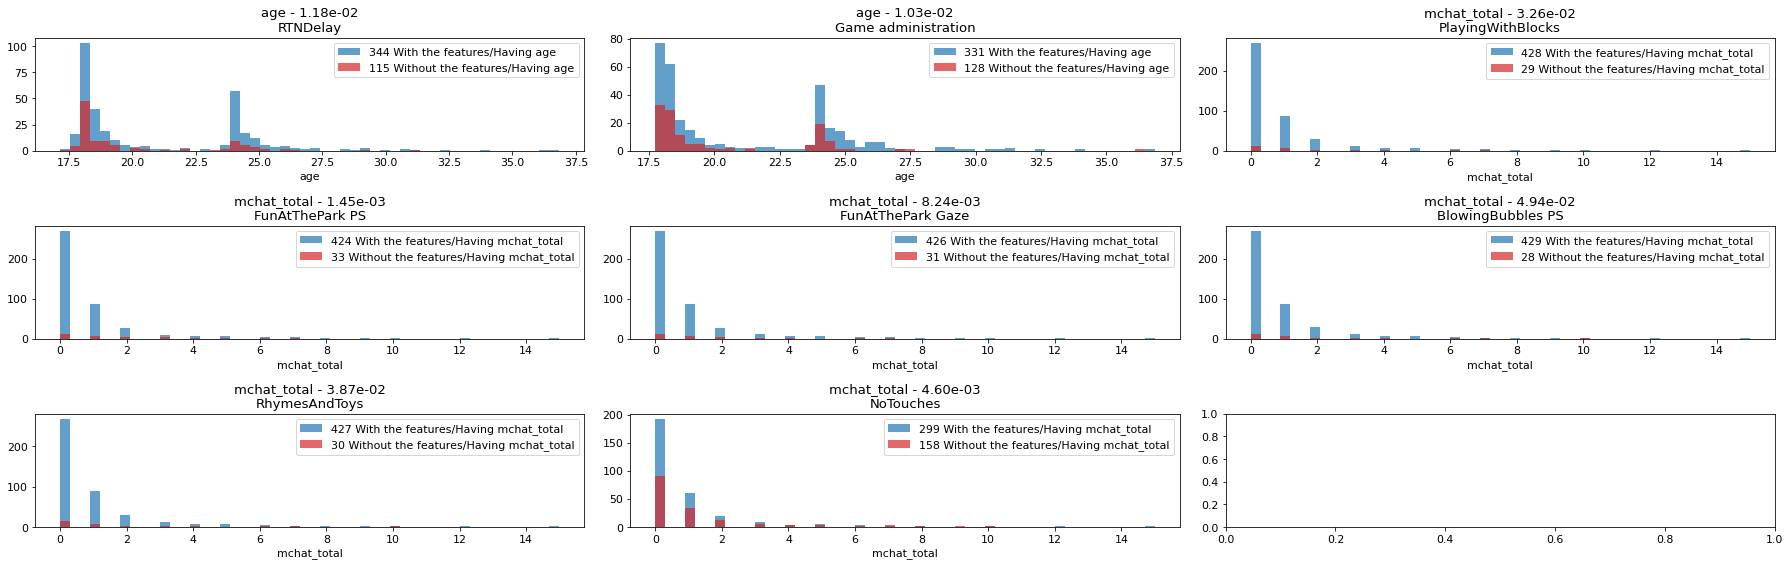

In [106]:
mask  = (mcar_matrix<0.05).astype(int)

locations = [(index, column) for index in mask.index for column in mask.columns if mask.loc[index, column]==1]

fig, axes = plt.subplots(len(locations)//3+1, 3, figsize=(25, 8));axes = axes.flatten()
for j, (var, idx) in enumerate(locations):
    feats = grouped_features[idx]
    
    d = data.df.copy()

    having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
    missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
    
    _, bins, _ = axes[j].hist(having, density=False, bins = 50, color='tab:blue', label='{} With the features/Having {}'.format(len(having), var), alpha=.7)
    axes[j].hist(missing, bins = bins, density=False, color='tab:red', label='{} Without the features/Having {}'.format(len(missing), var), alpha=.7)
    axes[j].set_title("{} - {:.2e}\n{}".format(var, mcar_matrix.loc[var, idx], idx));axes[j].set_xlabel(var)
    axes[j].legend()
plt.tight_layout()

### Categorical Variables

In [107]:
variables_of_interest = list(grouped_features.values())
vars = ['StateOfTheChild','SiblingsInTheRoom','ShotsVaccines','Distractions','FamilyMemberDistract','PetDistract',
        'PetNoiseDistract','DoorbellPhoneDistract','TVOnDistract','OtherDistract','SittingUp','Hungry','Diaper','AppTeamComment',
        'Comments','sex','diagnosis','ados_total','ados_rrb','ados_sa','mchat_result']

from scipy.stats import chi2_contingency
mcar_matrix = pd.DataFrame(data=np.zeros(shape=(len(vars), len(variables_of_interest))),
                            columns=list(grouped_features.keys()),
                            index=vars)

In [108]:
for i, feats in grouped_features.items():

    for j, var in enumerate(vars):
        
        d = data.df.copy()
            
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
        missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
        
        
        
        table = pd.crosstab(d['Z_grouped_{}'.format(i)], d[var]).to_numpy()
        
        stat, p, dof, expected = chi2_contingency(np.array(table))
        
        values_with = d[d['Z_grouped_{}'.format(i)]==0][var].dropna()
        values_without = d[d['Z_grouped_{}'.format(i)]==1][var].dropna()
        
        if len(values_with) < 20 or len(values_without) < 20:
            mcar_matrix.loc[var, i] = np.nan
            continue

    
        mcar_matrix.loc[var, i] = p
    

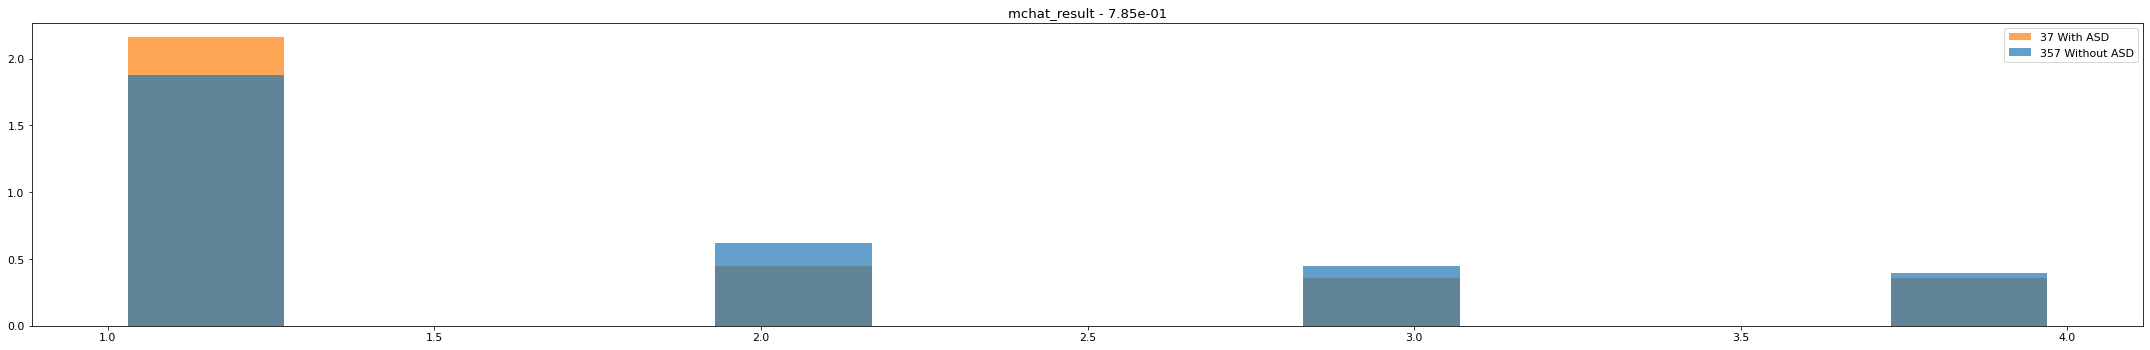

0.38466702472380765

In [124]:
having = data.df[data.df['diagnosis']==1]['StateOfTheChild'].dropna()
missing = data.df[data.df['diagnosis']==0]['StateOfTheChild'].dropna()

fig, ax = plt.subplots(1, 1, figsize=(30, 5))
_, bins, _ = ax.hist(having,color='tab:orange',density=True, rwidth=.8, label='{} With ASD'.format(len(having)), alpha=.7)
ax.hist(missing, density=True, bins = bins, color='tab:blue', rwidth=.8, label='{} Without ASD'.format(len(missing)), alpha=.7)
locs = axes[j].get_yticks(); axes[j].set_yticklabels(np.round(locs/len(having)*100,3))
ax.set_title("{} - {:.2e}".format(var, mcar_matrix.loc[var, i]))
ax.legend()
plt.tight_layout();plt.show()

mannwhitneyu(having, missing).pvalue

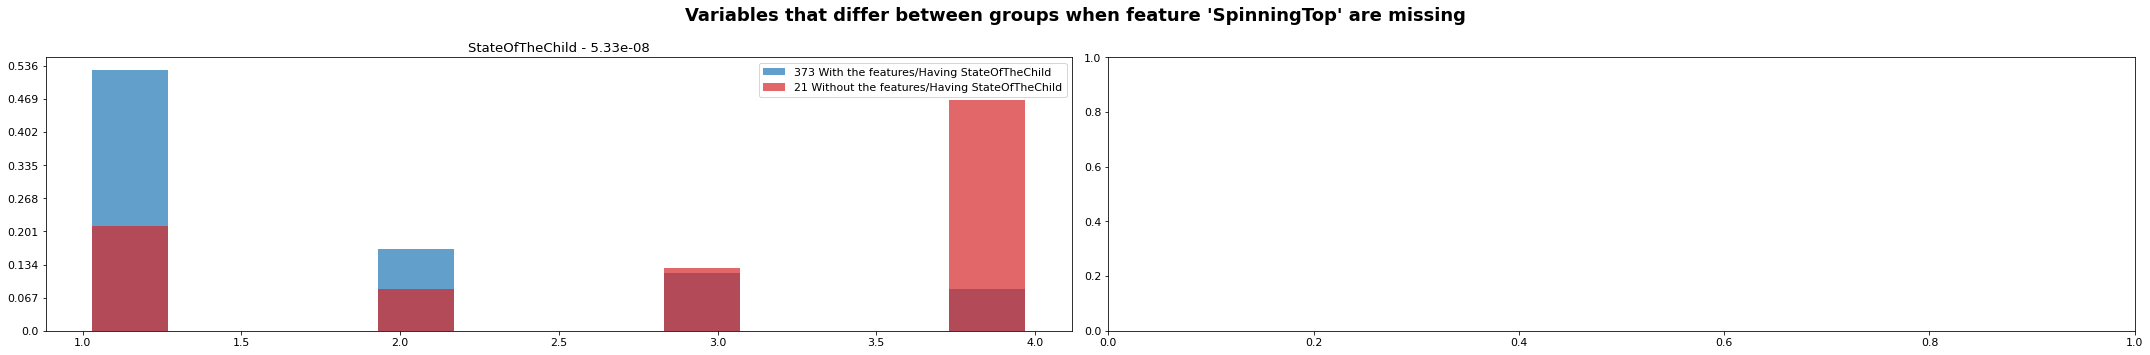

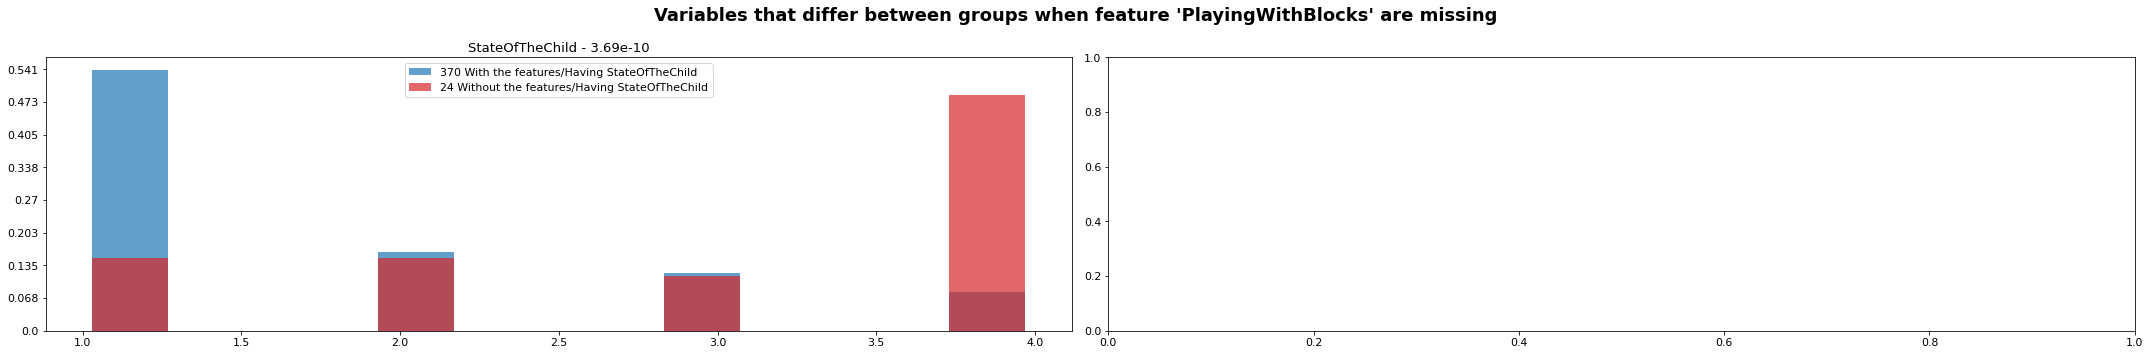

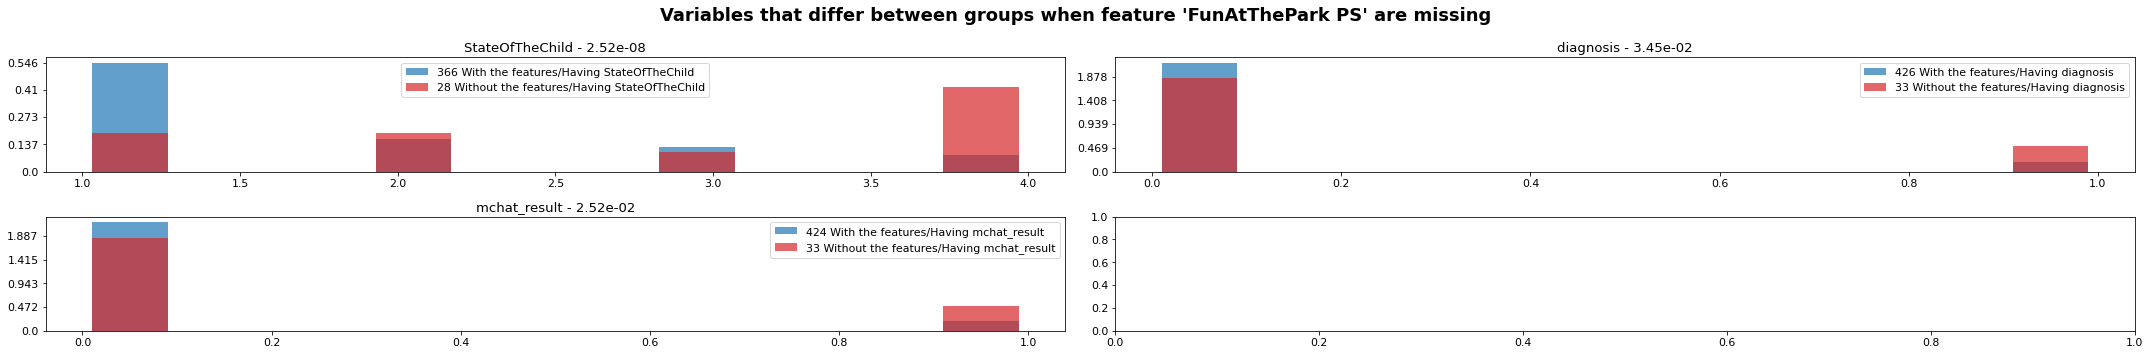

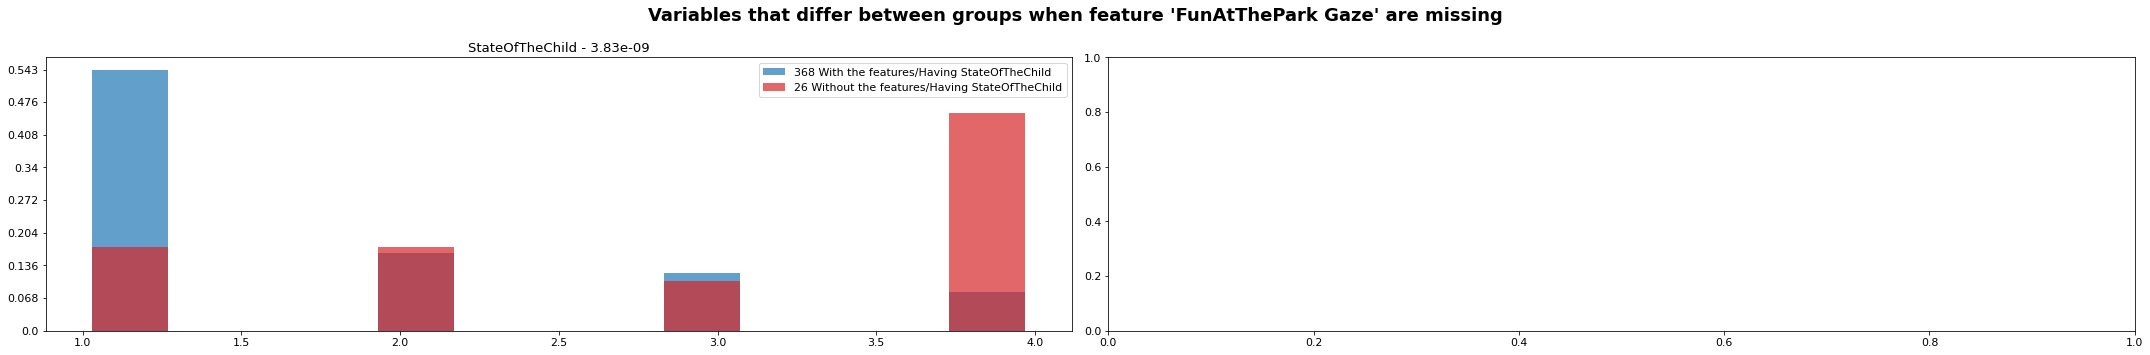

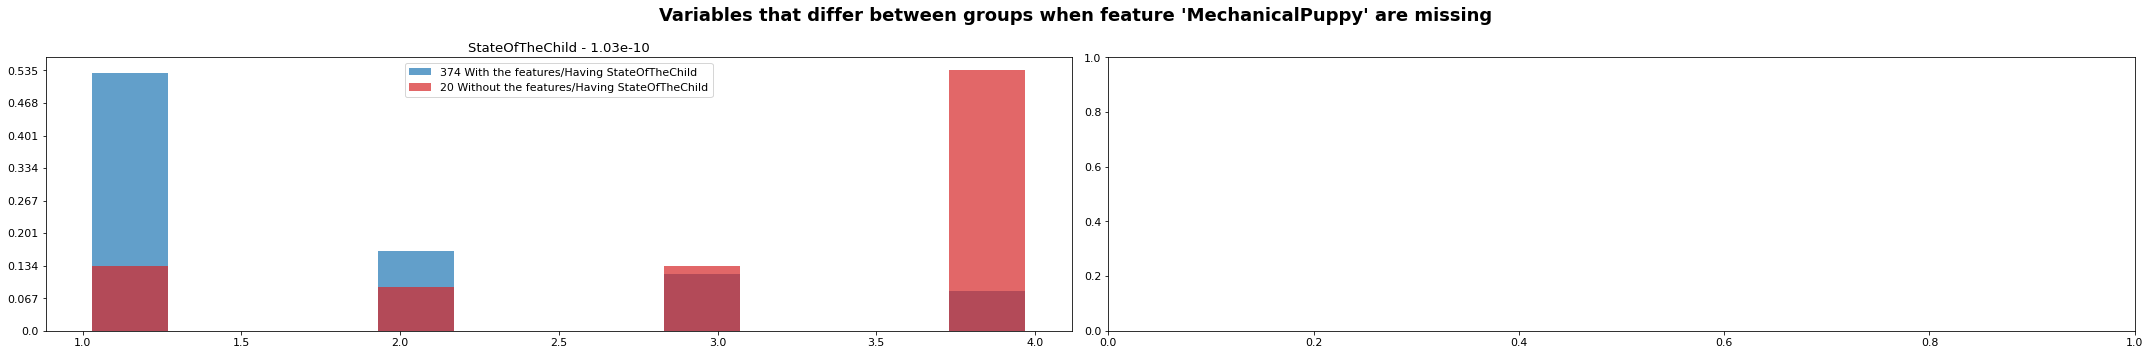

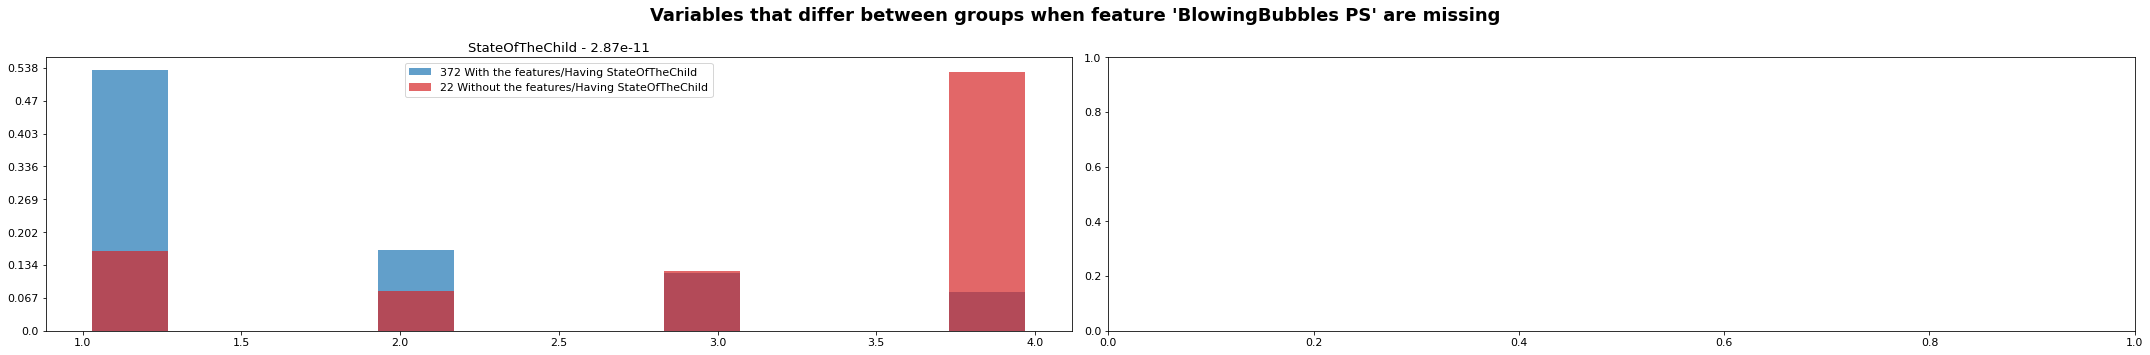

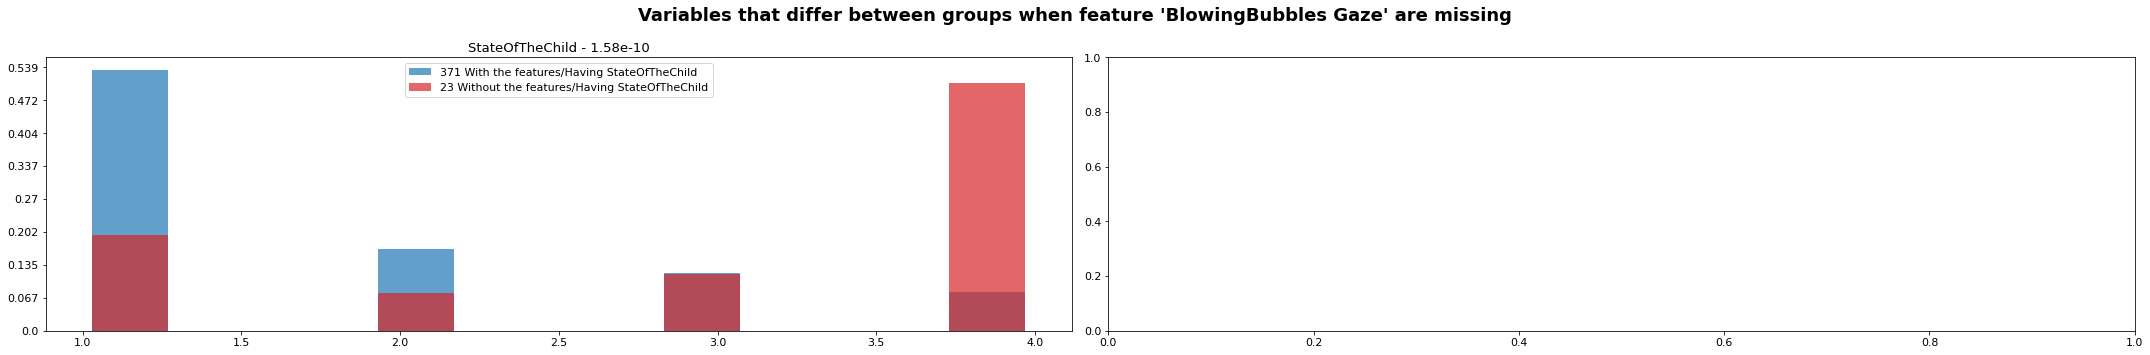

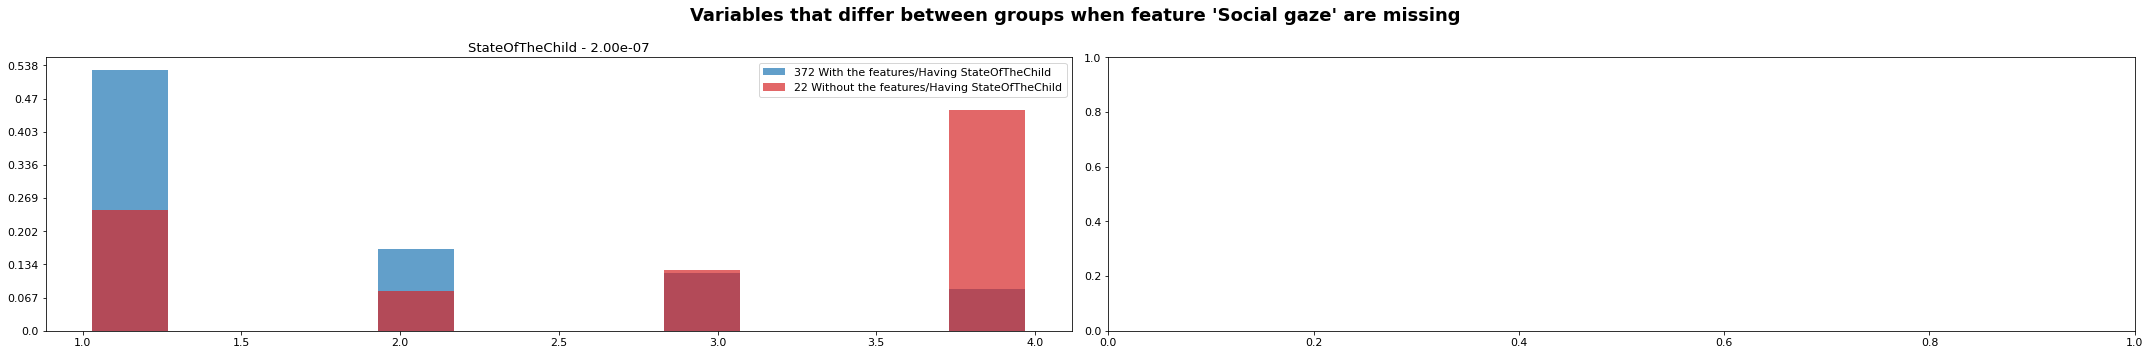

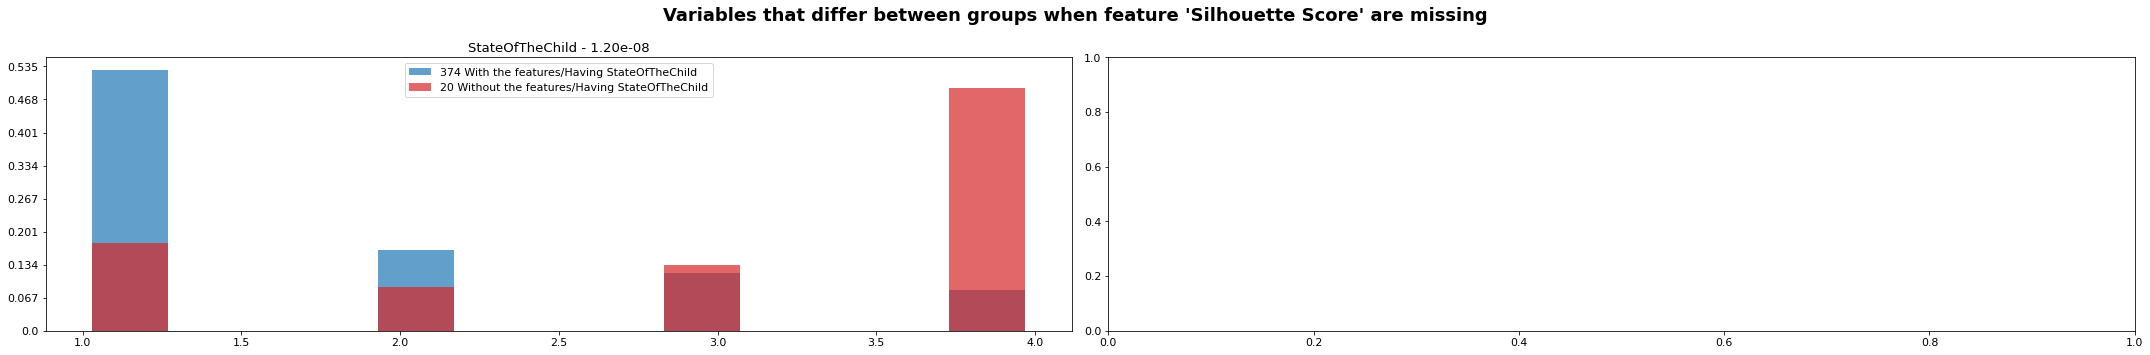

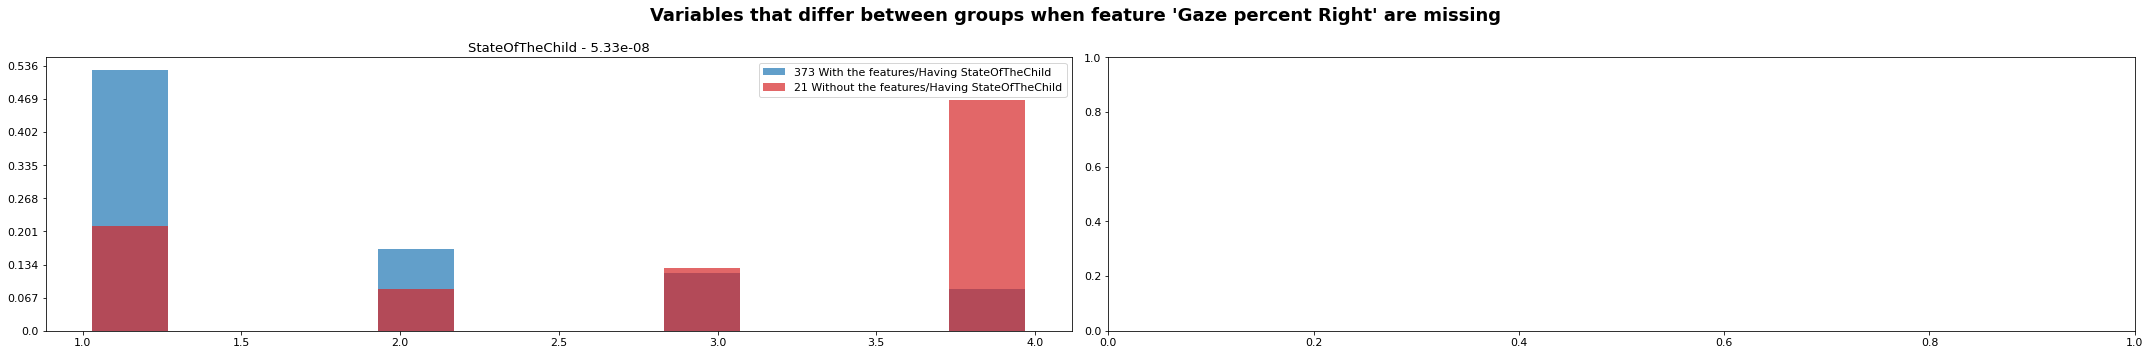

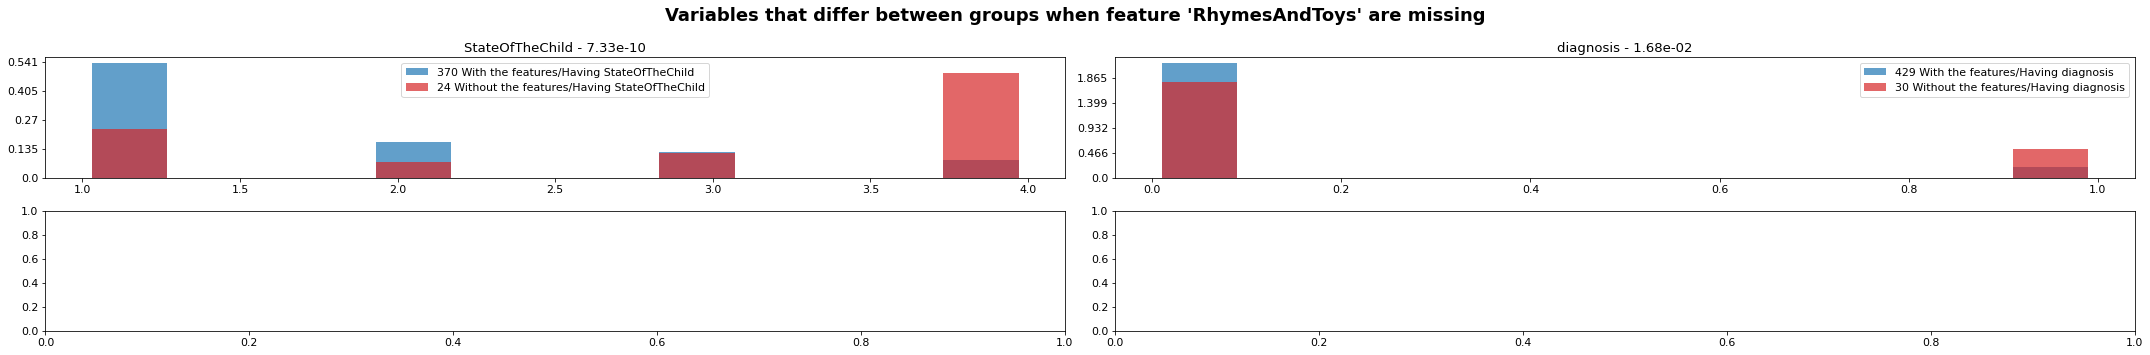

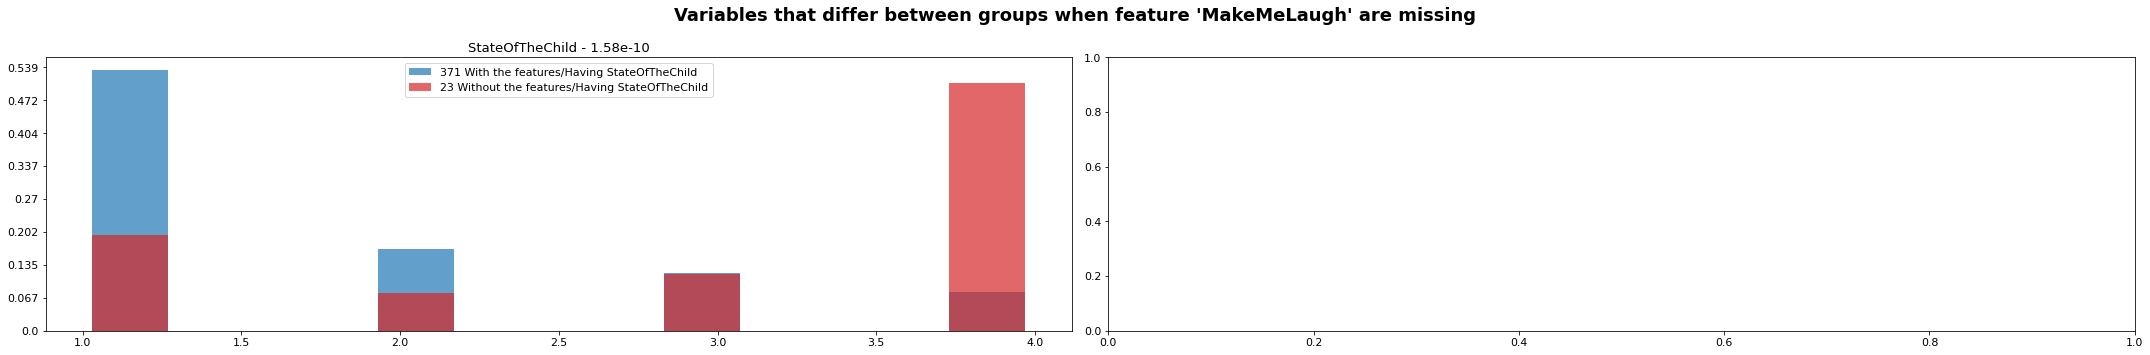

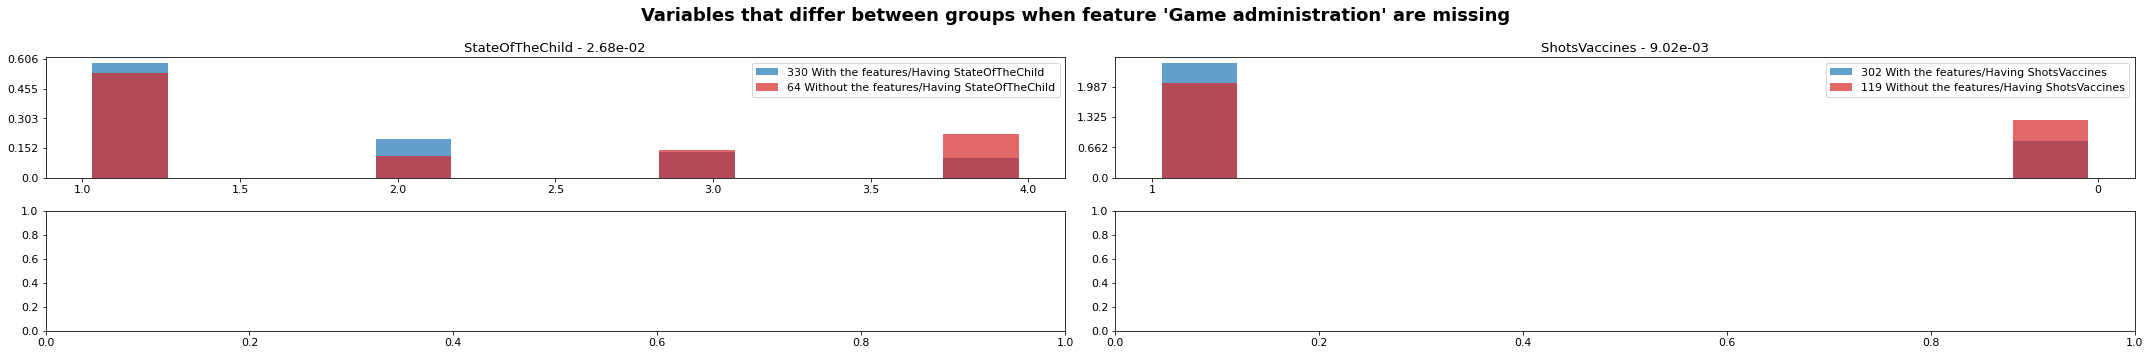

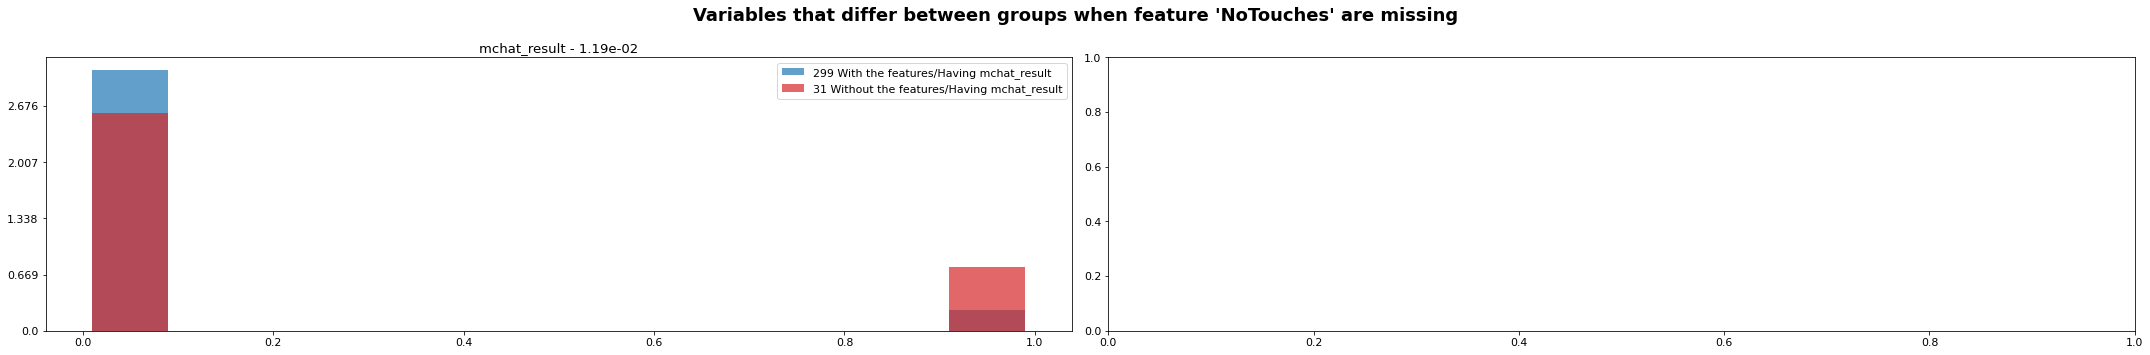

In [109]:
mask  = (mcar_matrix<0.05).astype(int)

locations = [(index, column) for index in mask.index for column in mask.columns if mask.loc[index, column]==1]
for i, row in mask.transpose().iterrows():
    
    variables_with_interactions = list(row[row==1].index)
    n_plot = len(variables_with_interactions)
    if n_plot==0:
        continue

    fig, axes = plt.subplots(n_plot//2+1, 2, figsize=(30, 5));axes = axes.flatten()
    fig.suptitle("Variables that differ between groups when feature '{}' are missing".format(i), weight='bold', fontsize=18)
    for j, var in enumerate(variables_with_interactions):
        feats = grouped_features[i]
        
        d = data.df.copy()

        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = d[d['Z_grouped_{}'.format(i)]==0][var].dropna()
        missing = d[d['Z_grouped_{}'.format(i)]==1][var].dropna()
        
        _, bins, _ = axes[j].hist(having,color='tab:blue',density=True, rwidth=.8, label='{} With the features/Having {}'.format(len(having), var), alpha=.7)
        axes[j].hist(missing, density=True, bins = bins, color='tab:red', rwidth=.8, label='{} Without the features/Having {}'.format(len(missing), var), alpha=.7)
        locs = axes[j].get_yticks(); axes[j].set_yticklabels(np.round(locs/len(having)*100,3))
        axes[j].set_title("{} - {:.2e}".format(var, mcar_matrix.loc[var, i]))
        axes[j].legend()
    plt.tight_layout();plt.show()

# Prediction of the missing variables

In [ ]:
for i, feats in grouped_features.items():
    data.df['Z_grouped_{}'.format(i)] = 0
    data.df.loc[data.df.drop(index=data.df.dropna(subset=feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1

touch_features =  ['number_of_touches','average_length','std_length','average_error','std_error','number_of_target','pop_rate',
 'average_touch_duration','std_touch_duration','average_delay_to_pop','std_delay_to_pop','average_force_applied','std_force_applied',
 'average_accuracy_variation','accuracy_consistency','average_touches_per_target', 'std_touches_per_target','average_time_spent','std_time_spent','exploratory_percentage']

In [ ]:
from interpret import show

for idx_grouped_missing_features, missing_feats in grouped_features.items():
    
    df =  pd.read_csv("HIDDEN")

    df['study'] = df['path'].apply(lambda x: x.split('/')[-3] if x.split('/')[-3] in S2K_STUDIES else x.split('/')[-4])
    
    for i, feats in grouped_features.items():
        df['Z_grouped_{}'.format(i)] = 0
        df.loc[df.drop(index=df.dropna(subset=missing_feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1
    del i 
    
    features_name = [feat for feat in CVA_COLUMNS + CLINICAL_COLUMNS + VALIDITY_COLUMNS if (((idx_grouped_missing_features not in [8, 9, 10]) and (feat not in missing_feats)) or
                                                                                        ((idx_grouped_missing_features in [11, 12, 13, 14, 15, 16]) and (feat not in touch_features)) or
                                                                                        (feat not in ['completed']))]

    data = Dataset(df=df, 
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                       outcome_column='Z_grouped_{}'.format(idx_grouped_missing_features),
                    features_name = CVA_COLUMNS, 
                    scale_data=True,
                    use_missing_indicator_variables=False,
                   verbosity=4,
                   scenario='papers',
                   proportion_train=1)    
    
    exp = Experiments(data.dataset_name,
              dataset=data, 
            approach='ebm', 
            resolution=RESOLUTION, 
            bandwidth=BANDWIDTH, 
            previous_experiment=None,        
            verbosity=1, 
            debug=True, 
            save_experiment=False)
        
    
    print(grouped_features_label[idx_grouped_missing_features])

    if idx_grouped_missing_features in dict_check_1_0.keys():
        for idx_group_that_should_be_there in dict_check_1_0[idx_grouped_missing_features]:
            exp.dataset.df = exp.dataset.df[exp.dataset.df['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
    exp.fit_predict(num_cv=16)
    exp.plot()

    ebm_local = exp.model.explain_local(data.X_train, data.y_train)
    show(ebm_local)

['FB_postural_sway', 'FB_postural_sway_derivative']

 ['BB_gaze_percent_right', 'BB_gaze_silhouette_score', 'S_gaze_percent_right', 'S_gaze_silhouette_score', 'FP_gaze_speech_correlation', 'FP_gaze_silhouette_score', 'proportion_of_name_call_responses', 'average_response_to_name_delay', 'name_call_response_binary', 'FB_postural_sway', 'FB_postural_sway_derivative', 'DIGC_postural_sway', 'DIGC_postural_sway_derivative', 'DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative', 'ST_postural_sway', 'ST_postural_sway_derivative', 'MP_postural_sway', 'MP_postural_sway_derivative', 'PB_postural_sway', 'PB_postural_sway_derivative', 'BB_postural_sway', 'BB_postural_sway_derivative', 'RT_postural_sway', 'RT_postural_sway_derivative', 'MML_postural_sway', 'MML_postural_sway_derivative', 'PWB_postural_sway', 'PWB_postural_sway_derivative', 'FP_postural_sway', 'FP_postural_sway_derivative', 'number_of_touches', 'average_length', 'std_length', 'average_error', 'std_error', 'number_of_target', 'po

,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting Z_grouped_0 based on 85 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Floating Bubbles
Encoding 459 (train) and 0 (test) missing values with -5.
